In [1]:
from toolkit.logger import Logger
from toolkit.classes import DataFrameCreator
from toolkit.pytorch_tools import CustomImageDataLoader
from toolkit.pytorch_tools import NeuralNetwork
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import Normalize
from torchvision.transforms import ToPILImage
from torchvision.transforms import ToTensor
# from torchvision.transforms import RandomHorizontalFlip
# from torchvision.transforms import RandomVerticalFlip
# from torchvision.transforms import RandomRotation
# from torchvision.transforms import RandomPerspective

from torchsummary import summary

import torch
import gc

In [2]:
torch.cuda.empty_cache()
gc.collect()
logger = Logger("main").get_logger()

In [3]:
data = DataFrameCreator()

samples = ["./data/sd1_sample"]

In [4]:
for sample in samples:
    data.load_dataset(
        sample_dir=sample, labels={"non_defective": 0, "defective": 1}
    )
data.split_dataset()
data.info()
data["dataset"].head()

[    INFO    ] Images loaded from ./data/sd1_sample with label non_defective
[    INFO    ] Images loaded from ./data/sd1_sample with label defective
[    INFO    ] Name :          dataset
[    INFO    ] Type:           ('dataset',)
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc', 'type')
[    INFO    ] Shape:          (8733, 6)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          train
[    INFO    ] Type:           ('dataset',)
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc', 'type')
[    INFO    ] Shape:          (6289, 6)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          validation
[    INFO    ] Type:           ('dataset',)
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc', 'type')
[    INFO    ] Shape:          (1746, 6)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          test
[    INFO    ] Type:           ('dataset',)
[

,img_dir,img_file,img,label,label_enc,type
0,data/sd1_sample/non_defective,img_00000.jpg,data/sd1_sample/non_defective/img_00000.jpg,non_defective,0,dataset
1,data/sd1_sample/non_defective,img_00001.jpg,data/sd1_sample/non_defective/img_00001.jpg,non_defective,0,dataset
2,data/sd1_sample/non_defective,img_00002.jpg,data/sd1_sample/non_defective/img_00002.jpg,non_defective,0,dataset
3,data/sd1_sample/non_defective,img_00003.jpg,data/sd1_sample/non_defective/img_00003.jpg,non_defective,0,dataset
4,data/sd1_sample/non_defective,img_00004.jpg,data/sd1_sample/non_defective/img_00004.jpg,non_defective,0,dataset


In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
input_size = (256, 64)

transform = {
    "train": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
    "validation": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
    "test": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
}
target_transform = {
    "train": None,
    "validation": None,
    "test": None,
}

loader = CustomImageDataLoader(
    dataset=data,
    image_col="img",
    label_col="label_enc",
    transform=transform,
    target_transform=target_transform,
)
loader.create_dataloaders(batch_size=8)

[    INFO    ] CustomImageDataSet created
[    INFO    ] Setting dataloader subprocesses to 8
[    INFO    ] Dataloaders created


In [6]:
model = NeuralNetwork(name="test", encoder_name="VGG19", encoder_weights="IMAGENET1K_V1", num_classes=3)
model.init_device(device="cpu")
# model.results.create_dashboard(interval=10)
# model.results.dashboard.run_server()

[    INFO    ] Model filename: results/test/20230419_221319.pth
[    INFO    ] Results filename: results/test/20230419_221319.csv
[    INFO    ] Neural Network constructed: test
[    INFO    ] NeuralNetwork(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, k

In [8]:
summary(model, input_size=(3, *input_size), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 256, 64]           1,792
              ReLU-2          [-1, 64, 256, 64]               0
            Conv2d-3          [-1, 64, 256, 64]          36,928
              ReLU-4          [-1, 64, 256, 64]               0
         MaxPool2d-5          [-1, 64, 128, 32]               0
            Conv2d-6         [-1, 128, 128, 32]          73,856
              ReLU-7         [-1, 128, 128, 32]               0
            Conv2d-8         [-1, 128, 128, 32]         147,584
              ReLU-9         [-1, 128, 128, 32]               0
        MaxPool2d-10          [-1, 128, 64, 16]               0
           Conv2d-11          [-1, 256, 64, 16]         295,168
             ReLU-12          [-1, 256, 64, 16]               0
           Conv2d-13          [-1, 256, 64, 16]         590,080
             ReLU-14          [-1, 256,

In [9]:
epochs = 10

model.train_net(epochs=epochs, train_loader=loader["train"], validation_loader=loader["validation"])

[    INFO    ] Model training started
[    INFO    ] Epoch:    0 Loss:  0.1683 Validation loss:  0.0919   
[    INFO    ] Epoch:    1 Loss:  0.0854 Validation loss:  0.0815   
[    INFO    ] Epoch:    2 Loss:  0.0782 Validation loss:  0.0762   
[    INFO    ] Epoch:    3 Loss:  0.0734 Validation loss:  0.0801   
[    INFO    ] Epoch:    4 Loss:  0.0704 Validation loss:  0.0701   
[    INFO    ] Epoch:    5 Loss:  0.0679 Validation loss:  0.0684   
[    INFO    ] Epoch:    6 Loss:  0.0658 Validation loss:  0.0657   
[    INFO    ] Epoch:    7 Loss:  0.0641 Validation loss:  0.0657   
[    INFO    ] Epoch:    8 Loss:  0.0629 Validation loss:  0.0632   
[    INFO    ] Epoch:    9 Loss:  0.0618 Validation loss:  0.0636   


In [10]:
model.results.data

,loss,accuracy,validation_loss,validation_acc
0,0.168271,0.0,0.091934,0.0
1,0.085362,0.0,0.081497,0.0
2,0.078238,0.0,0.076248,0.0
3,0.073408,0.0,0.080081,0.0
4,0.070370,0.0,0.070100,0.0
5,0.067896,0.0,0.068413,0.0
6,0.065780,0.0,0.065695,0.0
7,0.064106,0.0,0.065748,0.0
8,0.062887,0.0,0.063205,0.0
9,0.061801,0.0,0.063558,0.0


In [11]:
model.save_model(epoch=model.results.data.index[-1], loss=model.results.data["loss"].iloc[-1])
model.results.save_data()

[    INFO    ] Model saved to results/test/20230419_221319.pth
[    INFO    ] Results saved to: results/test/20230419_221319.csv


TypeError: 'AxesSubplot' object is not subscriptable

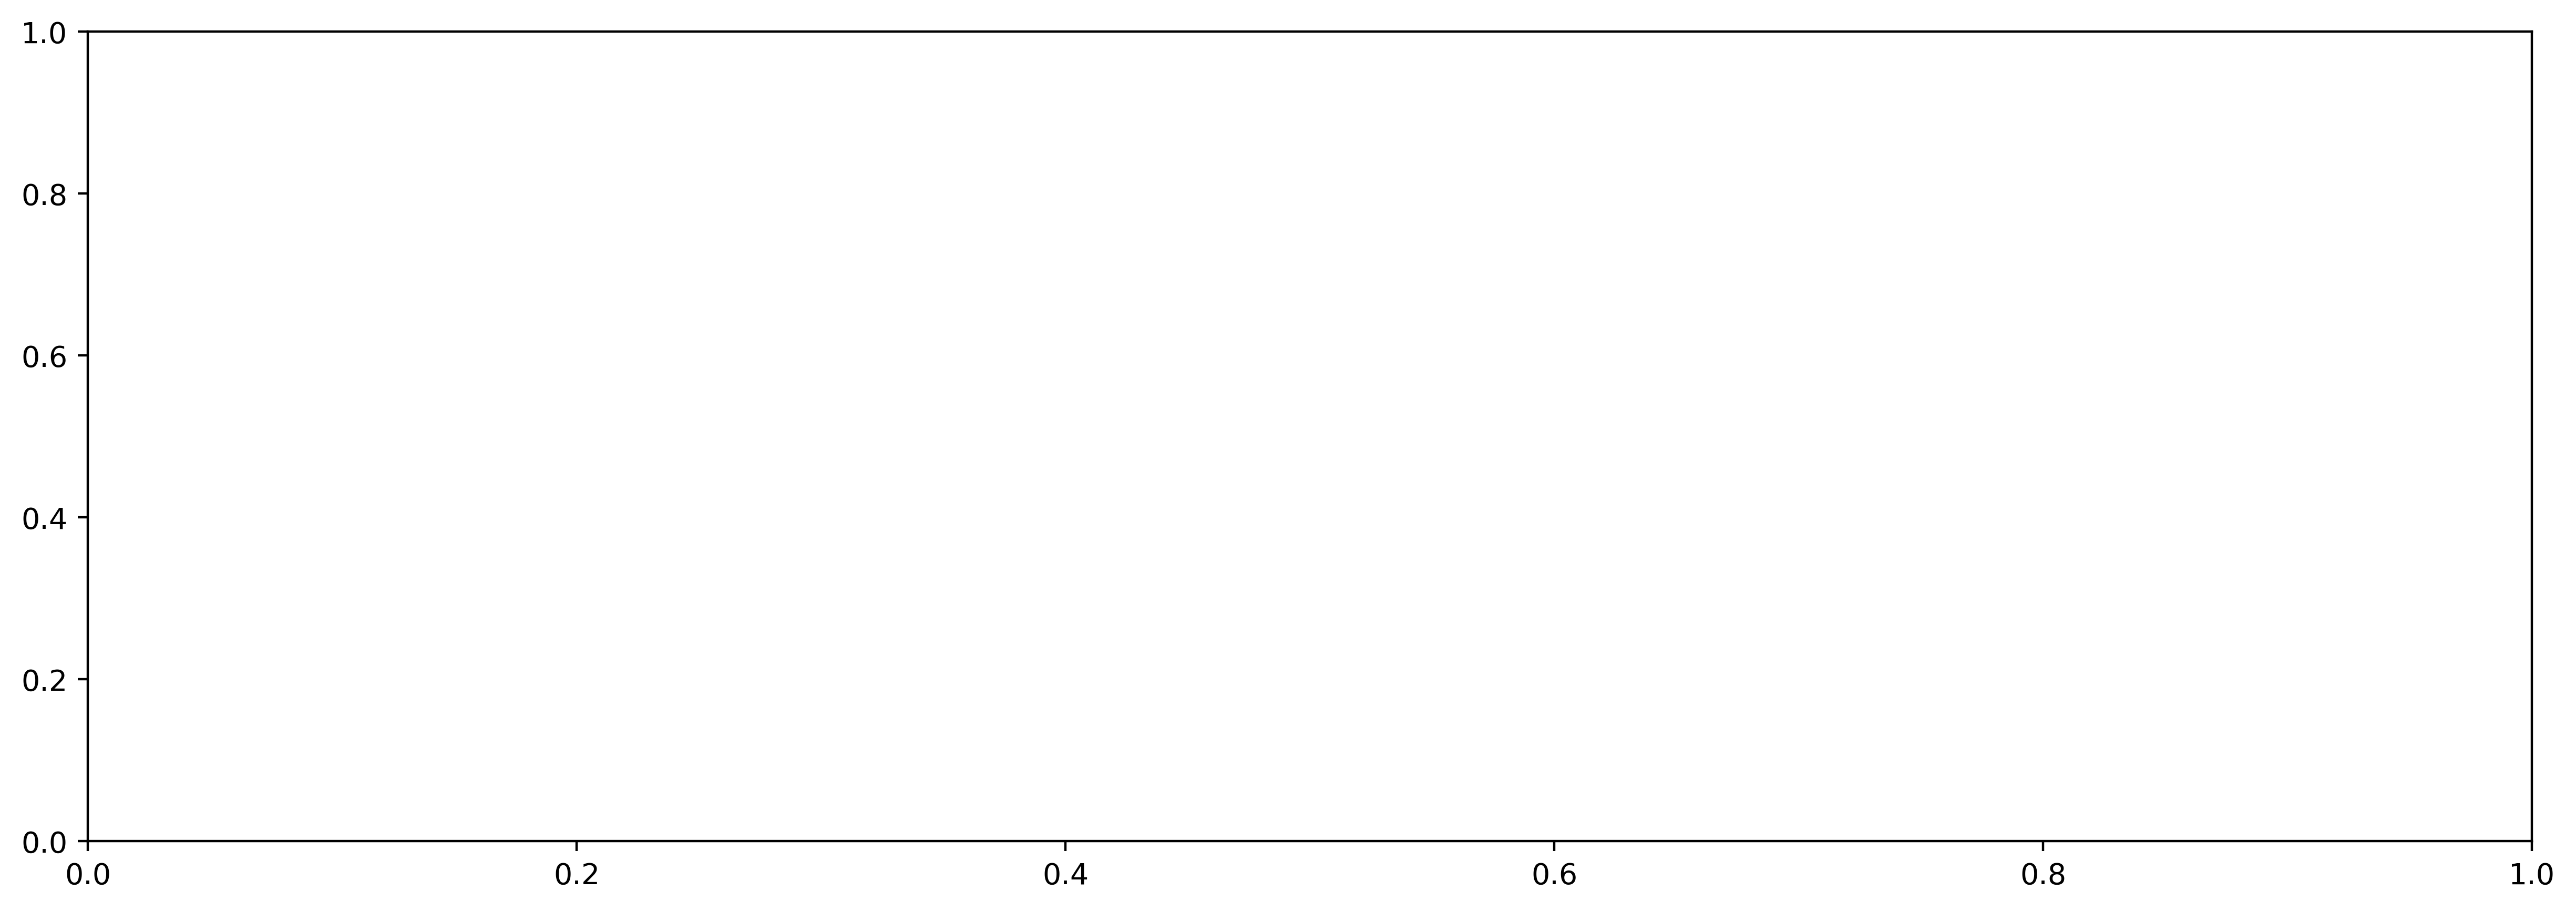

In [12]:
model.results.plot()

In [20]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [21]:
pred = [
    model.predict(data["train"].iloc[1].img, transform=transform["train"])
    .detach()
    .numpy()
    .flatten()
    for _ in tqdm(range(5000))
]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [22]:
pca = PCA(n_components=2)
res_pca = pca.fit_transform(np.array(pred))

<AxesSubplot: >

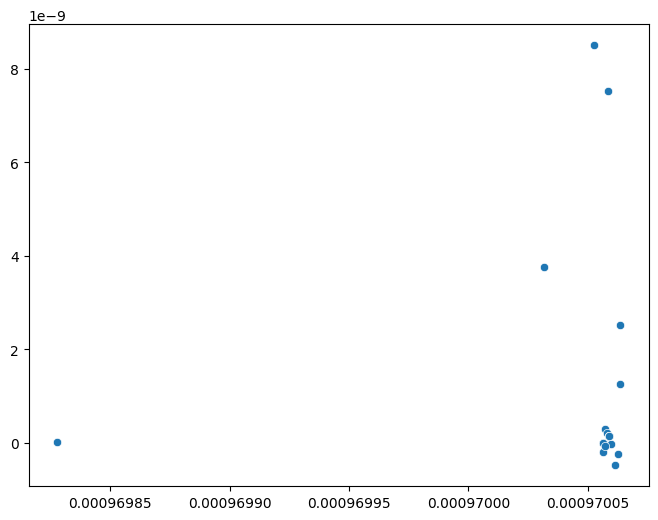

In [23]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(x=res_pca[:, 0], y=res_pca[:, 1],ax=ax)

In [24]:
pca.explained_variance_ratio_

array([9.999997e-01, 3.218362e-14], dtype=float32)

In [25]:
from sklearn.manifold import TSNE

In [30]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
res_tsne = tsne.fit_transform(np.array(pred))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.008s...
[t-SNE] Computed neighbors for 5000 samples in 3.819s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 0.000000
[t-SNE] KL divergence after 300 iterations: 0.000000


<AxesSubplot: >

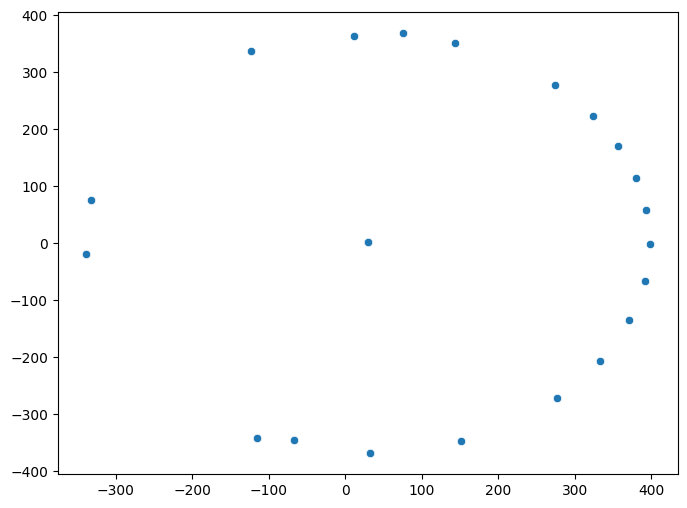

In [31]:
_, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(x=res_tsne[:, 0], y=res_tsne[:, 1],ax=ax)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...
[t-SNE] Computed neighbors for 5000 samples in 0.351s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.761967
[t-SNE] KL divergence after 300 iterations: 0.128795


<AxesSubplot: >

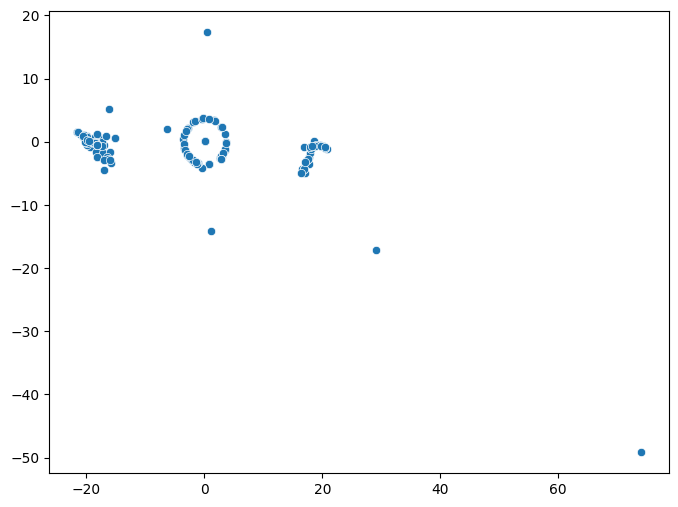

In [32]:
pca = PCA(n_components=50)
res_pca = pca.fit_transform(np.array(pred))
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
res_tsne = tsne.fit_transform(res_pca)
_, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(x=res_tsne[:, 0], y=res_tsne[:, 1],ax=ax)